


# Stable Baselines contrib - qrDQN & HER

Github Repo:
[https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/blob/75b2de139927da26d5871aef9fd839632f73b296/sb3_contrib/qrdqn/qrdqn.py]

In [1]:
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz

  Created wheel for box2d-kengz: filename=Box2D_kengz-2.3.3-cp37-cp37m-linux_x86_64.whl size=2023555 sha256=a1f1531d48ea914965db386994b9748c74926a0f623e0e7711653cf721178462
  Stored in directory: /root/.cache/pip/wheels/50/6d/6a/6ff76731fd9e8efbd1cdc6111e98b2dd0f1872184d7c28939c
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616826 sha256=b91c893e386bbbaca2d06e0140532279efe5836438953b177028d759045eeee7
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=a77fb7addcedb57f9fa359f9ba85c60063e1621e049ccdb69536702fbea1ca9b
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built box2d-kengz gym AutoROM.accept-rom-license
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
     

In [2]:

!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # render 

!pip install -U colabgymrender # for rendering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import policy, RL agent, Wrappers

In [4]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import HER, DQN,HerReplayBuffer
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
!pip install sb3-contrib

In [7]:
from sb3_contrib.ars import ARS
from sb3_contrib.ppo_mask import MaskablePPO
from sb3_contrib.qrdqn.policies import CnnPolicy, MlpPolicy, MultiInputPolicy
from sb3_contrib.qrdqn.qrdqn import QRDQN
# from sb3_contrib.ppo_recurrent.ppo_recurrent import RecurrentPPO # no longer working 
# from sb3_contrib.ppo_recurrent.policies import CnnLstmPolicy

In [8]:
%load_ext tensorboard


## Create and wrap the environment

We will be using Lunar Lander environment with continuous actions

In [9]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('SpaceInvaders-v0')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

## custom Callback Function


In [10]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

## Define and train the agent ( vanilla dqn )


In [7]:
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
dqn_model = DQN("CnnPolicy",
            env,
            verbose=1,
            train_freq=(10,'episode'),
            gradient_steps=8,
            gamma=0.95,
            exploration_fraction=0.01,
            exploration_final_eps=0.1,
            target_update_interval=600,
            buffer_size=10000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            seed=2)

# Train the agent
dqn_model.learn(total_timesteps=int(5e4), callback=callback)

Using cuda device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 210.00
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 2000
Best mean reward: 210.00 - Last mean reward per episode: 150.00
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 619      |
|    ep_rew_mean      | 151      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1173     |
|    time_elapsed     | 2        |
|    total_timesteps  | 2477     |
----------------------------------
Num timesteps: 3000
Best mean reward: 210.00 - Last mean reward per episode: 151.25
Num timesteps: 4000
Best mean reward: 210.00 - Last mean reward per episode: 158.33
Num timesteps: 5000
Best mean reward: 210.00 - Last mean reward per episode: 157.86
----------------------------------
| rollout/         

In [ ]:
dqn_model.save('dqn_50_10_episodes')

## Plotting helpers

Stable Baselines3 has some built-in plotting helper, that you can find in `stable_baselines3.common.results_plotter`. However, to show how to do it yourself, we are going to use custom plotting functions. 

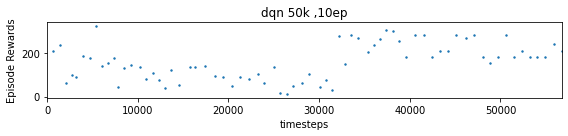

In [ ]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "dqn 50k ,10ep")

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()


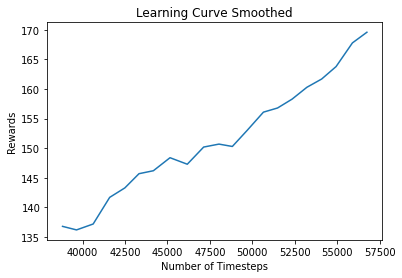

In [ ]:
plot_results(log_dir)

# running the game with the agent 

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # render 
!pip install -U colabgymrender # for rendering

In [ ]:
from colabgymrender.recorder import Recorder

directory = './video'
env = Recorder(env, directory)

observation = env.reset()
done = False
while not done:
  action, _states = dqn_model.predict(observation, deterministic=True)
  observation, rewards, dones, info = env.step(action)
  

env.play()
height, width, channels = env.observation_space.shape
actions = env.action_space.n

# trying qrdqn

In [12]:
tensorboard_log_train = "/content/train"


In [19]:
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
qrdqn_model = QRDQN("CnnPolicy",
            env,
            verbose=1,
            train_freq=20,
            gamma=0.95,
            exploration_fraction=0.01,
            exploration_final_eps=0.1,
            buffer_size=10000,
            learning_rate=3e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            seed=2)

# Train the agent
qrdqn_model.learn(total_timesteps=int(1e5), callback=callback, tb_log_name=tensorboard_log_train)

Using cuda device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 147.20
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 2000
Best mean reward: 147.20 - Last mean reward per episode: 148.35
Saving new best model to /tmp/gym/best_model.zip
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 619      |
|    ep_rew_mean      | 151      |
|    exploration rate | 0.1      |
| time/               |          |
|    episodes         | 4        |
|    fps              | 952      |
|    time_elapsed     | 2        |
|    total_timesteps  | 2477     |
----------------------------------
Num timesteps: 3000
Best mean reward: 148.35 - Last mean reward per episode: 149.55
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 4000
Best mean reward: 149.55 - Last mean reward per episode: 151.30
Saving new best model to /tmp/gym/best_m

In [20]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(qrdqn_model, qrdqn_model.get_env(), deterministic=True, n_eval_episodes=5)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:270.00 +/- 0.00


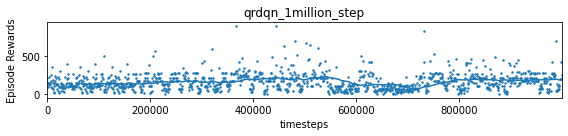

In [21]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e6, results_plotter.X_TIMESTEPS, "qrdqn_1million_step")

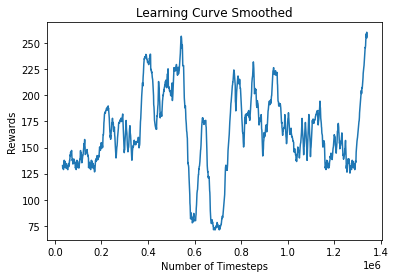

In [23]:
plot_results(log_dir)


# training for more (1 million qrdqn) 

In [ ]:
qrdqn_model.learn(total_timesteps=int(1e6), callback=callback, tb_log_name=tensorboard_log_train)

In [13]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=5)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:285.00 +/- 0.00


mean reward increased by only 15 but the agent realized trying new actions earlier than normal dqn

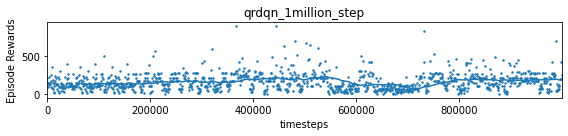

In [14]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e6, results_plotter.X_TIMESTEPS, "qrdqn_1million_step")

In [15]:
def moving_average(values, window):

    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()


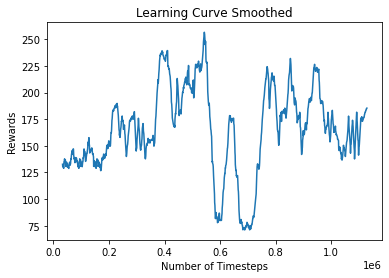

In [16]:
plot_results(log_dir)

In [ ]:
dqn_model.save('qrdqn')

In [ ]:
!unzip 'qrdqn.zip'

Archive:  qrdqn.zip
 extracting: data                    
 extracting: pytorch_variables.pth   
 extracting: policy.pth              
 extracting: policy.optimizer.pth    
 extracting: _stable_baselines3_version  
 extracting: system_info.txt         


In [ ]:
dqnreload = dqn_model.load('qrdqn')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=tensorboard_log_train

the model still needs more timesteps to learn

# trying hindsight replay integreted with dqn 

HER is no longer a seperate model

In [14]:
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy

In [ ]:
goal_selection_strategy = 'future' 
max_episode_length= 200
# If True the HER transitions will get sampled online
online_sampling = True
HER_model = DQN

model = HER_model("MultiInputPolicy",
    env,
    replay_buffer_class=HerReplayBuffer,
    # Parameters for HER
    replay_buffer_kwargs= dict(
        goal_selection_strategy=goal_selection_strategy,
        online_sampling=online_sampling,
        max_episode_length=max_episode_length,
    ))
# Train the agent
model.learn(total_timesteps=int(1e4), callback=callback)